<b>CONNECT TO COLAB AND IMPORT</b>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import os
import sys
from scipy import ndimage
import imutils
from scipy.optimize import minimize
from scipy.spatial import distance
import numpy as np
import cv2
from sklearn.preprocessing import MinMaxScaler as ms
from matplotlib import pyplot as plt
%matplotlib inline

try:
  os.mkdir('drive/MyDrive/eschergrid')
except: 
  pass
finally:  
  try: os.chdir('drive/MyDrive/eschergrid')
  except: print('ERROR')
  
print('PLEASE LOAD CIPOLLINA\'s "eschergrid.zip" TO THE NEWLY CREATED FOLDER IN COLAB!')


ERROR
PLEASE LOAD CIPOLLINA's "eschergrid.zip" TO THE NEWLY CREATED FOLDER IN COLAB!


In [3]:
!unzip -n fwdeschergrid.zip 

Archive:  fwdeschergrid.zip


In [4]:
files = [
 'escher_grid CUADRADO 3 B.png',
 'escher_grid CUADRADO 5 B.png',
 'escher_grid CUADRADO 2 B.png',
 'escher_grid CUADRADO 4 B.png',
 'escher_grid CUADRADO 1 B.png',
 ]

images = {i:f'escher_grid CUADRADO {i} B.png' for i in range(1,6)}

In [ ]:
# This is PYVIPS, a "faster"
# alternative to what we will actually do

# %capture
# !apt-get update
# !apt-get upgrade
# !apt-get install libvips
# !pip install pyvips
# !pip install cffi
# !pip show pyvips

# import pyvips

<b>LOAD DATA AND VISUALIZE</b>

In [5]:
images = {k:cv2.imread(v) for k,v in images.items()}

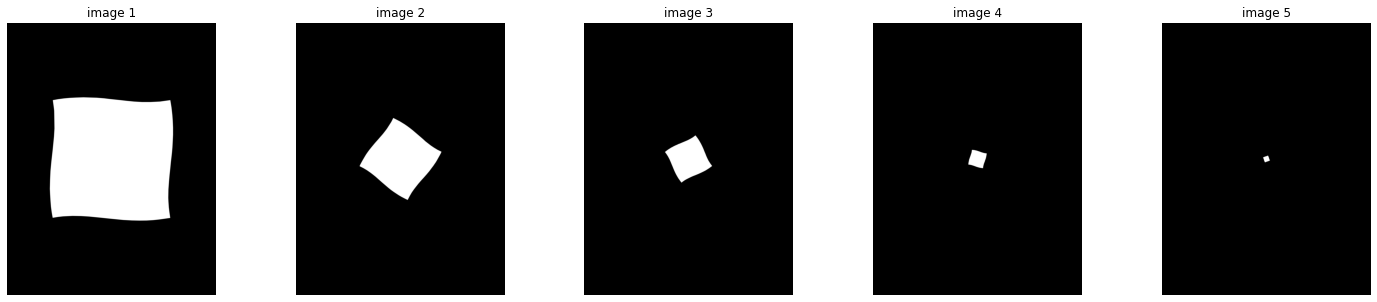

In [6]:
f, ax = plt.subplots(1,5, figsize=(25,5))
for i in range(5):
  ax[i].imshow(images[i+1])
  ax[i].set_axis_off()
  ax[i].set_title(f'image {i+1}')
plt.show()

<b>DEFINE THE FUNCTIONS TO ROTATE AND SCALE</b>

In [7]:
from scipy import ndimage
import imutils
from scipy.optimize import minimize
from scipy.spatial import distance

def rotate(img, deg: float):
  """
  rotates "deg" degrees
  clockwise
  """
  s = img.shape
  out = []

  # ndimage by scipy
  #out = ndimage.rotate(img, deg)

  # ndimage by scipy by sectors
  # out = np.concatenate([ndimage.rotate(images[1][:,:,0], deg)[:,:,np.newaxis],
  #               ndimage.rotate(images[1][:,:,1], deg)[:,:,np.newaxis],
  #               ndimage.rotate(images[1][:,:,2], deg)[:,:,np.newaxis]], axis=2)

  # imutils rotator
  out=imutils.rotate_bound(img, deg)

  s2 = out.shape

  if s2[0]<s[0]: raise Exception('rotation downsized it!')

  ind = [
        slice(
            int((s2[0])//2-s[0]//2),
            int((s2[0])//2+s[0]//2),
        ),
        slice(
            int((s2[1])//2-s[1]//2),
            int((s2[1])//2+s[1]//2),
        ),
  ]
  return out[ind[0],ind[1],:]



def scale(img, f: float):
  """
  scales by a factor "f"
  """
  s = img.shape
  width = int(img.shape[1] * f)
  height = int(img.shape[0] * f)
  dim = (width, height)
  if f>1:
    ind = [
           slice(
               int((s[0]*f)//2-s[0]//2),
               int((s[0]*f)//2+s[0]//2),
           ),
           slice(
               int((s[1]*f)//2-s[1]//2),
               int((s[1]*f)//2+s[1]//2),
           ),
    ]
    
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)[ind[0],ind[1],:]

  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

<b>original</b>

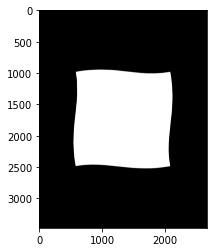

In [8]:
plt.imshow(images[1])

<b>rotated</b>

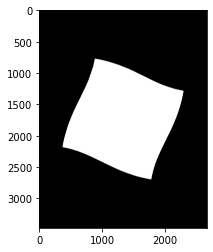

In [9]:
plt.imshow(rotate(images[1],20))

<b>zoomed</b>

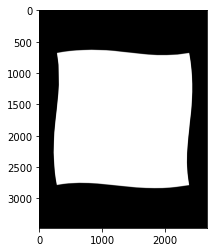

In [10]:
plt.imshow(scale(images[1],1.4))

<b>zoomed and rotated</b>

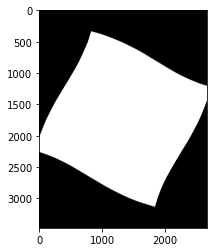

In [11]:
plt.imshow(scale(rotate(images[1],25),1.4))

<b>CONVERT FROM "uint8" to "float"</b>

In [12]:
for k in images.keys():
  images[k] = images[k].astype(float)

<b>DEFINE THE FUNCTION TO OPTIMIZE</b>

In [28]:
global_counter = 1
L = len(images[1].flatten())
history = {2:[],3:[],4:[],5:[]}

def optimize_image(deg, f, n: int = [2,3,4,5][0], hist: bool=False):

  #global global_counter
  #print('global call N',global_counter)
  #global_counter += 1

  if f<1: return np.inf
  #out = np.linalg.norm(-images[n-1].reshape(-1,) +
  #                      scale(rotate(images[n],deg),f).reshape(-1,))/L
  out = np.linalg.norm(-images[n-1].reshape(-1,) +
                        rotate(scale(images[n],f),deg).reshape(-1,))/L
  if hist:
    history[n].append((deg, f, out))

  return out
  

<b>APPLY THE SIMONE SEGMENTED OPTIMIZATION PROCESS</b>

In [40]:

def simone_method(IMAGE):
  """
  IMAGE must be 2,3,4 or 5
  """
  # Initialize the angle and the scaling factor
  # 1 degree (almost 0, the identity) and a scaling factor of "1" (identity)
  degree, scaling = 1,1

  # Define the optimizer
  minimizer = lambda x,y: minimize(x,y,
                                  method=["BFGS","Nelder-Mead"][1],
                                  options={'maxiter':50}
                                  )
  # Four  iterations
  for _ in range(4):

    # even iterations are for the scaling factor
    if _%2==0:

      res = minimizer(
                lambda x: optimize_image(degree,x, IMAGE, True),
                scaling,
                )
      
      # update the scaling factor
      scaling = res.x[0]

    # odd iterations are for the degrees
    else:

      res = minimizer(
            lambda Y: optimize_image(Y, scaling, IMAGE, True),
                degree, 
                )
      
      # update the rotation angle
      degree = res.x[0]

    # print the last params
    print(f'parameters after lap {_+1} are: ',res.x)

  return degree, scaling 

In [30]:
results = {2:None, 3:None, 4:None, 5:None}

for n in [2,3,4,5]:
  results[n] = simone_method(n)

parameters after lap 1 are:  [1.88164063]
parameters after lap 2 are:  [-31.02431641]
parameters after lap 3 are:  [1.9775602]
parameters after lap 4 are:  [-34.52629216]
parameters after lap 1 are:  [1.59970703]
parameters after lap 2 are:  [-26.54433594]
parameters after lap 3 are:  [1.68844078]
parameters after lap 4 are:  [-26.53024074]
parameters after lap 1 are:  [2.1640625]
parameters after lap 2 are:  [0.96855469]
parameters after lap 3 are:  [2.1640625]
parameters after lap 4 are:  [-41.16934393]
parameters after lap 1 are:  [2.73046875]
parameters after lap 2 are:  [37.46142578]
parameters after lap 3 are:  [2.84352722]
parameters after lap 4 are:  [36.68591436]


<b>PLOT THE PARAMETERS AND COST DURING THE OPTIMIZATION PROCESS</b>

In [51]:
def show(n):

  f, ax = plt.subplots(figsize=(20,4))

  deg, sc, cost = zip(*history[n])
  xvec = range(len(deg))

  sdeg = ms().fit([[x] for x in deg])
  ax.plot(sdeg.transform([[x] for x in deg]), c='orange')
  ax.scatter(xvec, sdeg.transform([[x] for x in deg]), label='degrees', c='orange')
  #ax.hlines(sdeg.transform([[30]])[0],0,len(sc), color='orange', ls=":", label='optimal degrees')

  ax.plot(sc, c='b')
  ax.scatter(xvec, sc, label='scaling', c='b')
  #ax.hlines(1.9,0,len(deg),color='b', ls=":", label='optimal scaling')

  ax.plot(ms().fit_transform([[x] for x in cost]), c='k')
  ax.scatter(range(len(deg)),ms().fit_transform([[x] for x in cost]), label='cost', c='k' )

  ax.set_ylim(-0.3,3.2)
  ax.legend()
  plt.show()

  f,ax = plt.subplots(1,3, figsize=(14,10))
  ax[2].imshow(scale(rotate(images[n],results[n][0]),results[n][1]).astype('uint8'))
  ax[1].imshow(images[n-1].astype('uint8'))
  ax[0].imshow(images[n].astype('uint8'))
  ax[2].set_title(f'optimized\nDEG:{results[n][0]} , SCALE:{results[n][1]}')
  ax[1].set_title('TARGET') 
  ax[0].set_title('BASE')
  plt.show()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

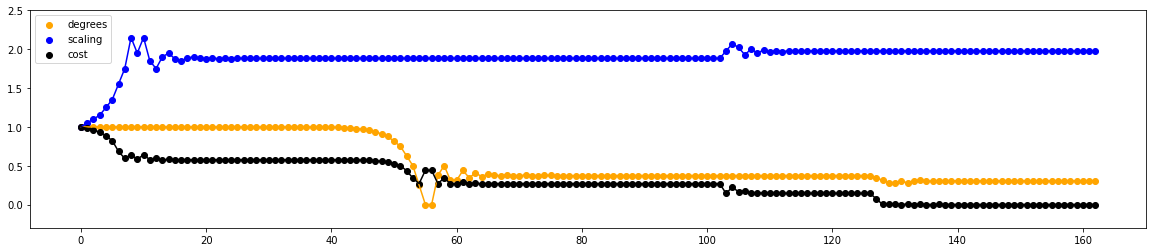

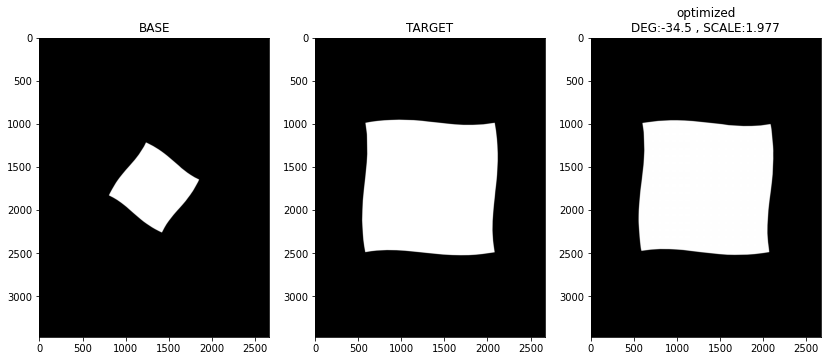

In [47]:
show(2)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

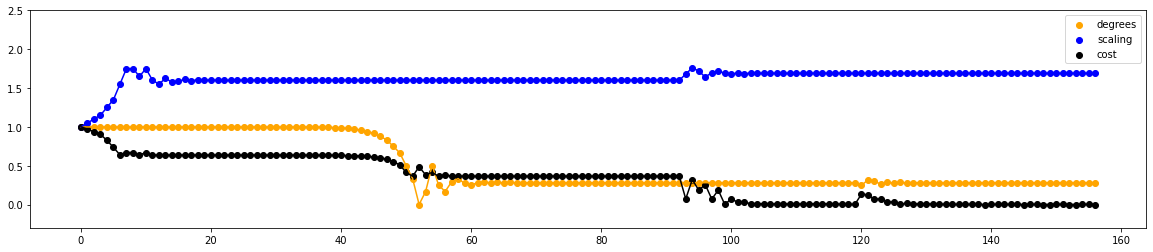

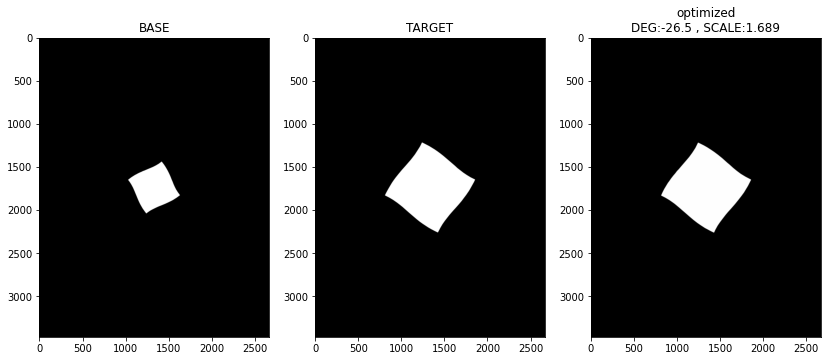

In [48]:
show(3)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

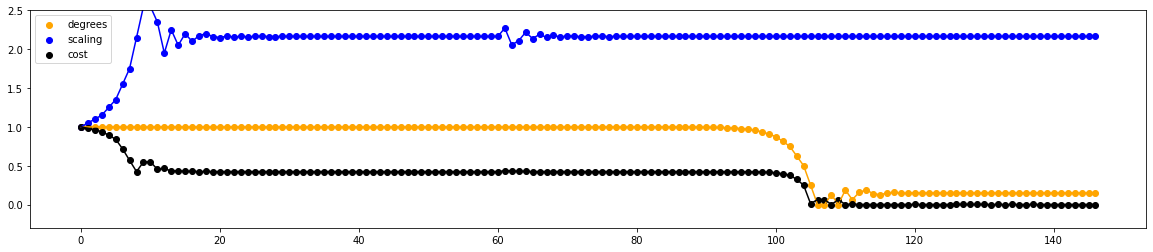

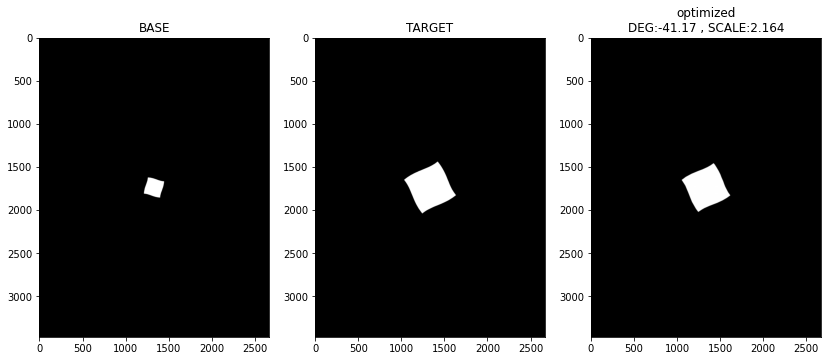

In [49]:
show(4)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

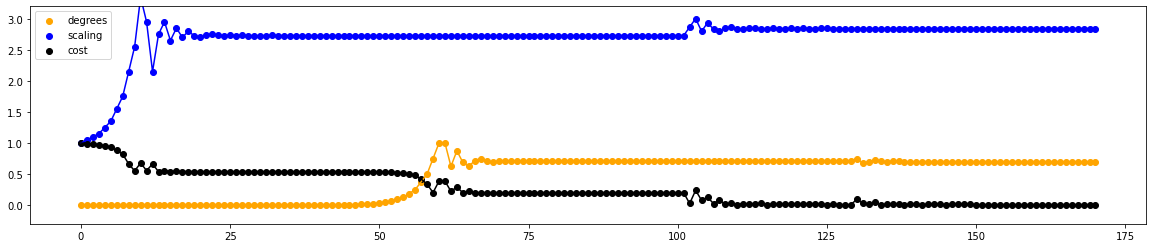

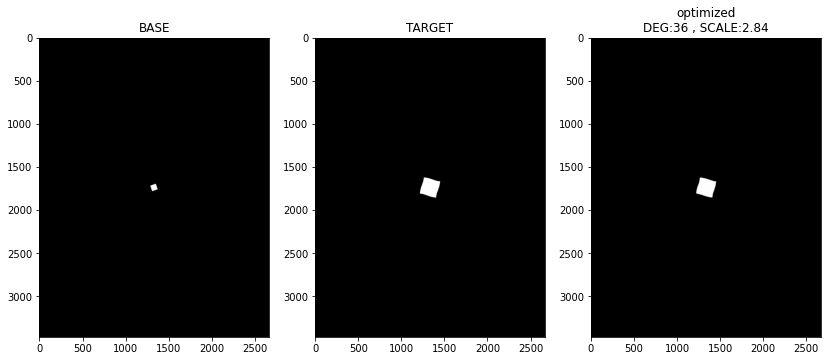

In [52]:
show(5)

<b>THE PARAMETERS FOR EACH</b>

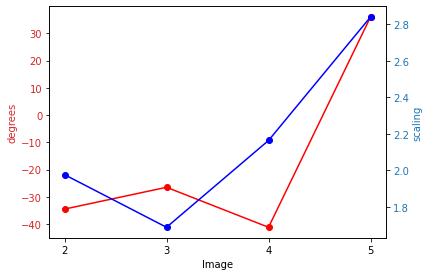

In [62]:
degrees, scaling = [],[]
for i in [2,3,4,5]:
  local = results[i]
  degrees.append(local[0])
  scaling.append(local[1])

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Image')
ax1.set_ylabel('degrees', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks([2,3,4,5])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('scaling', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


ax1.scatter([2,3,4,5], degrees, label="degrees", c='r')
ax1.plot([2,3,4,5],degrees, c='r')
ax2.scatter([2,3,4,5], scaling, label="scaling", c='b')
ax2.plot([2,3,4,5],scaling, c='b')
#ax1.legend()
#ax2.legend()
plt.show()